<a href="https://colab.research.google.com/github/brunofernandez-blip/TFG/blob/main/MCMC(NB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This section validates the Nanbu-Babovsky (NB) numerical scheme by applying it to the Kac equation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson


# Normalization constants for the Kac equation solution
K = (2.0 / np.sqrt(np.pi))
mu = (np.sqrt(np.pi)/2)

def C(t):
  return 1/(3 - 2*np.exp((- np.sqrt(np.pi)*t)/16))
#function C(t) defined in the article

def f(v,t):
    """
    Exact analytical solution
    """
    # case t = 0
    if t == 0:
        return  (v**2) * np.exp(-v**2)

    Ct = C(t)
    term1 = 1.5 * (1 - Ct) * np.sqrt(Ct)
    term2 = (3 * Ct - 1) * (Ct**1.5) * (v**2)

    return (np.exp(-Ct * v**2) * 0.5 * (term1 + term2))

def f_as(v):
  """
    Asymptotic function defined in the article
  """
    return 0.5*(1/np.sqrt(3))*np.exp(-(1/3)*v**2)

def W(x):
  """
    Function W defined in the article
  """
  ax = np.abs(x)
  if ax <= 0.5:
    return 0.75 - ax**2
  elif ax<=1.5:
    return (ax-1.5)**2*0.5
  else:
    return 0.0

def W_H(x,h):
  """
    Smoothing function defined in the article
  """
  return (1.0/h)*W(x/h)

def iround(x):
  """
    Iround function defined in the article
  """
  integer = int(x)
  p = np.random.rand()
  if p < x-integer:
    return integer + 1
  else:
    return integer

def collision(vi,vj):
  """
  Update of velocities
  """
  theta = np.random.uniform(0, 2*np.pi)
  vi_new = vi * np.cos(theta) - vj * np.sin(theta)
  vj_new = vi * np.sin(theta) + vj * np.cos(theta)
  return vi_new, vj_new

def f0(n):
    """
    returns an aleatory sample of exactly n particles with distribution
    p(v) = (2/sqrt(pi)) * v^2 * exp(-v^2)
    using gamma method.
    """
    # sample n values of a gamma(shape=1.5, scale=1.0)
    # this is y = v^2
    y = np.random.gamma(shape=1.5, scale=1.0, size=n)

    # obtain v making square root
    v_abs = np.sqrt(y)

    # assign a random -1,1 sign for each value
    signs = np.random.choice([-1, 1], size=n)

    samples = v_abs * signs

    return samples

def run_simulation(v0, n_steps, N, time_step, mu, epsilon):
    """
    Performs the Nanbu-Babovsky DSMC simulation.

    """
    print(f"Starting simulation: N={N}, mu={mu}, eps={epsilon}, dt={time_step}")

    # Initialize velocity matrix to store velocity at each time step
    v = np.zeros((len(v0), n_steps + 1))
    v[:, 0] = v0

    for t in range(n_steps):
        # Copy previous state
        v[:, t+1] = v[:, t]

        # Calculate number of collisions
        Nc = iround((mu * N * time_step) / (2 * epsilon))

        if Nc == 0:
            continue

        # Select particles (Indices)
        try:
            # Randomly select 2*Nc unique particles
            colliding_indices = np.random.choice(N, 2 * Nc, replace=False)
        except ValueError:
            # More collisions needed than particles available
            # print(f"Warning at t={t}: Saturation reached")
            colliding_indices = np.random.permutation(N)
            Nc = N // 2

        # Split into pairs
        idx_i = colliding_indices[:Nc]
        idx_j = colliding_indices[Nc:]


        vi = v[idx_i, t+1]
        vj = v[idx_j, t+1]

        theta = np.random.uniform(0, 2 * np.pi, size=Nc)
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)

        vi_new = vi * cos_theta - vj * sin_theta
        vj_new = vi * sin_theta + vj * cos_theta

        v[idx_i, t+1] = vi_new
        v[idx_j, t+1] = vj_new

    return v

def grid_f(v, Vmin, Vmax, deltaV, H, time):
  '''
  'grid' defined in the article
  '''
  VI = np.arange(Vmin, Vmax, deltaV)
  fVI = np.zeros_like(VI)
  for i, VIi in enumerate(VI):
      fVI[i] = np.sum([W_H(VIi - vj, H) for vj in v[:,time]]) / len(v[:,time])
  return VI, fVI

def compute_l2_error(VI, fVI, current_time):
    """
    Calculates the L2 norm difference between numerical approximation and exact solution.
    """

    # fVI (from grid_f) has area 1. fVI/K has area ~0.886
    fVI_desnormalized = fVI / K

    # f_exact_on_grid (from f) has area ~0.886
    f_exact_on_grid = f(VI, current_time)

    # compute integral to obtain error L2
    squared_diff = (fVI_desnormalized - f_exact_on_grid)**2
    integral = simpson(squared_diff, VI)
    l2_error = np.sqrt(integral)
    return l2_error


Performing a test simulation.


In [ ]:
#determine parameters for the simulation
N = 50000
time_max = 8
epsilon = 1
time_step = 1
n_steps = int(time_max/time_step)
v0 = f0(N) #inicial velocities

v = run_simulation(v0,n_steps,N,time_step, mu, epsilon)

# mesh parameters
Vmin, Vmax = -5, 5
deltaV = 0.0625
H = 0.2

VI, fVI = grid_f(v, Vmin, Vmax, deltaV, H, 2)#generate the mesh


Starting simulation: N=50000, mu=0.8862269254527579, eps=1, dt=1


Representing the test simulation. The analytical solution, the f(VI) solution, and the histogram of the numerical solution for t=2.

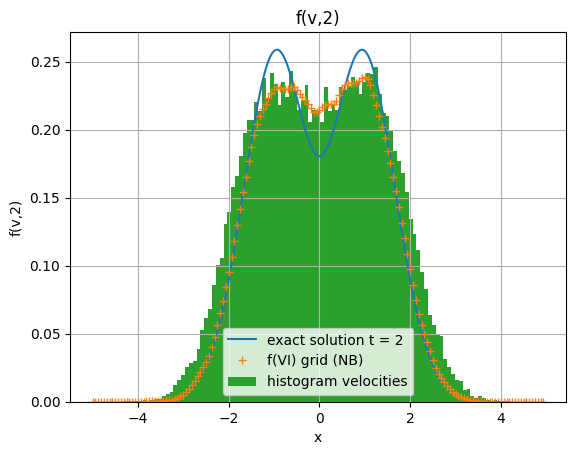

In [ ]:
x = np.linspace(-3,3,2000)
y = plt.plot(x, f(x,2), label = "exact solution t = 2")
plt.plot(VI, fVI/K,'+', label='f(VI) grid (NB)')
plt.hist(v[:,2]*K, bins = 100, density = True, label = 'histogram velocities')
plt.title("f(v,2)")
plt.xlabel("x")
plt.ylabel("f(v,2)")
plt.legend()
plt.grid(True)
#plt.xlim(-2, 2)
#plt.ylim(0.15, 0.3)
plt.show()

Plot of the analytical solution vs numerical solution f(VI) for t=2.

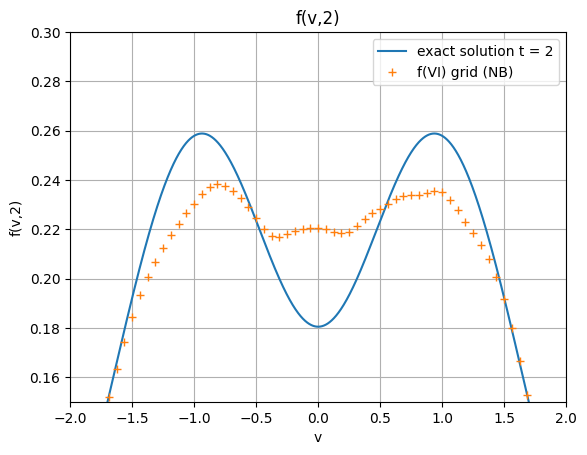

In [ ]:
x = np.linspace(-2,2,2000)
y = plt.plot(x, f(x,2), label = "exact solution t = 2")
plt.plot(VI, fVI/K,'+', label='f(VI) grid (NB)')

plt.title("f(v,2)")
plt.xlabel("v")
plt.ylabel("f(v,2)")
plt.legend()
plt.grid(True)
plt.xlim(-2, 2)
plt.ylim(0.15, 0.3)
plt.show()

We track the discrete $L^2$ error norm between the numerical reconstruction and the exact solution from t=0 to t=6, using Δt = 0.5.

Starting simulation with Δt = 0.5
Computing error in t=0...
t = 0.50 | Error L2 = 0.0206
t = 1.00 | Error L2 = 0.0213
t = 1.50 | Error L2 = 0.0202
t = 2.00 | Error L2 = 0.0199
t = 2.50 | Error L2 = 0.0167
t = 3.00 | Error L2 = 0.0154
t = 3.50 | Error L2 = 0.0120
t = 4.00 | Error L2 = 0.0114
t = 4.50 | Error L2 = 0.0117
t = 5.00 | Error L2 = 0.0100
t = 5.50 | Error L2 = 0.0086
t = 6.00 | Error L2 = 0.0088
completed simulation


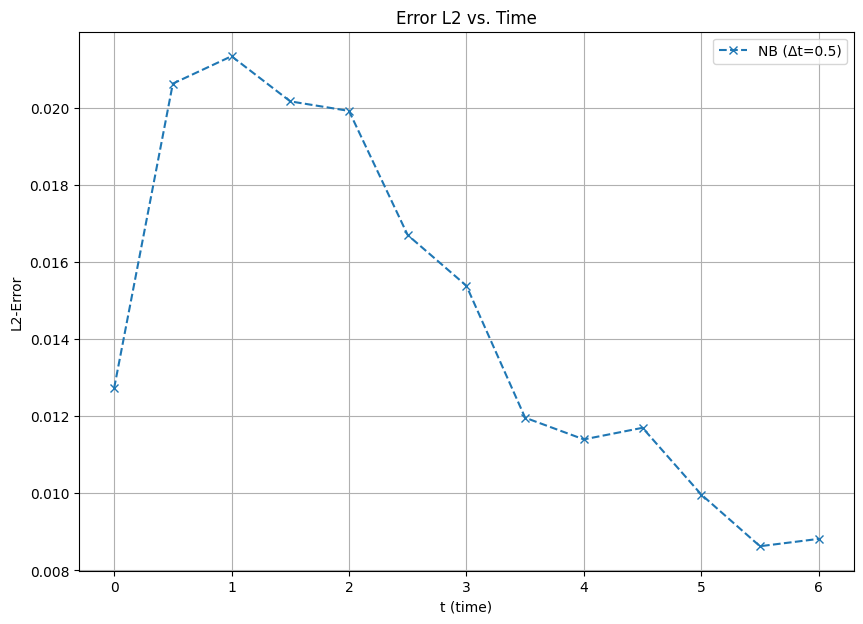

In [ ]:
# simulation parameters
from scipy.integrate import simpson
import numpy as np
import matplotlib.pyplot as plt

N = 50000
epsilon = 1
T_final = 6.0       # tmax
time_step = 0.5     # time_step
n_steps = int(T_final / time_step)

# mesh parameters
Vmin, Vmax = -5, 5 # ranges for the mesh
deltaV = 0.0625
H = 0.2

# initialize
v = np.zeros((N, n_steps + 1))
v[:,0] = f0(N)

# lists to store errors
time_points = []
error_list = []

print(f"Starting simulation with Δt = {time_step}")
print("Computing error in t=0...")

# error computation in t = 0
current_time = 0.0
VI, fVI = grid_f(v, Vmin, Vmax, deltaV, H, time=0)
f_exact_on_grid = f(VI, current_time)
squared_diff = (fVI/K - f_exact_on_grid)**2
integral = simpson(squared_diff, x=VI)
l2_error = np.sqrt(integral)

time_points.append(current_time)
error_list.append(l2_error)


# loop for simulation and errors
for t in range(n_steps):
    current_time = (t + 1) * time_step

    #simulation of first step
    v[:,t+1] = v[:,t]
    Nc = iround((mu*N*time_step)/(2*epsilon))

    if Nc > 0:
        try:
            colliding_indices = np.random.choice(N, 2 * Nc, replace=False)
            i_indx = colliding_indices[:Nc]
            j_indx = colliding_indices[Nc:]

            # simulate the collisions
            vi = v[i_indx, t+1]
            vj = v[j_indx, t+1]
            theta = np.random.uniform(0, 2*np.pi, Nc)

            v[i_indx, t+1] = vi * np.cos(theta) - vj * np.sin(theta)
            v[j_indx, t+1] = vi * np.sin(theta) + vj * np.cos(theta)

        except ValueError:
            print(f"Warning in t={t}: 2*Nc ({2*Nc}) > N ({N}).")
            # this is an error, if not continue without collision
            pass #

    # compute error for this time step
    VI, fVI = grid_f(v, Vmin, Vmax, deltaV, H, time=t+1)
    f_exact_on_grid = f(VI, current_time) # exact solution in same time time

    # integral error L2
    squared_diff = (fVI/K - f_exact_on_grid)**2
    integral = simpson(squared_diff, x=VI)
    l2_error = np.sqrt(integral)

    # store results
    time_points.append(current_time)
    error_list.append(l2_error)
    print(f"t = {current_time:.2f} | Error L2 = {l2_error:.4f}")

print("completed simulation")

# plotting
plt.figure(figsize=(10, 7))
plt.plot(time_points, error_list, marker='x', linestyle='--', label=f'NB (Δt={time_step})')
plt.title("Error L2 vs. Time")
plt.xlabel("t (time)")
plt.ylabel("L2-Error")
plt.legend()
plt.grid(True)
plt.show()

We track the discrete $L^2$ error norm between the numerical reconstruction and the exact solution from t=0 to t=6, using Δt = 0.5 and Δt = 0.2.

Starting simulation with Δt = 0.5
Computing error in t=0...
Starting simulation with Δt = 0.2
Computing error in t=0...
completed simulations


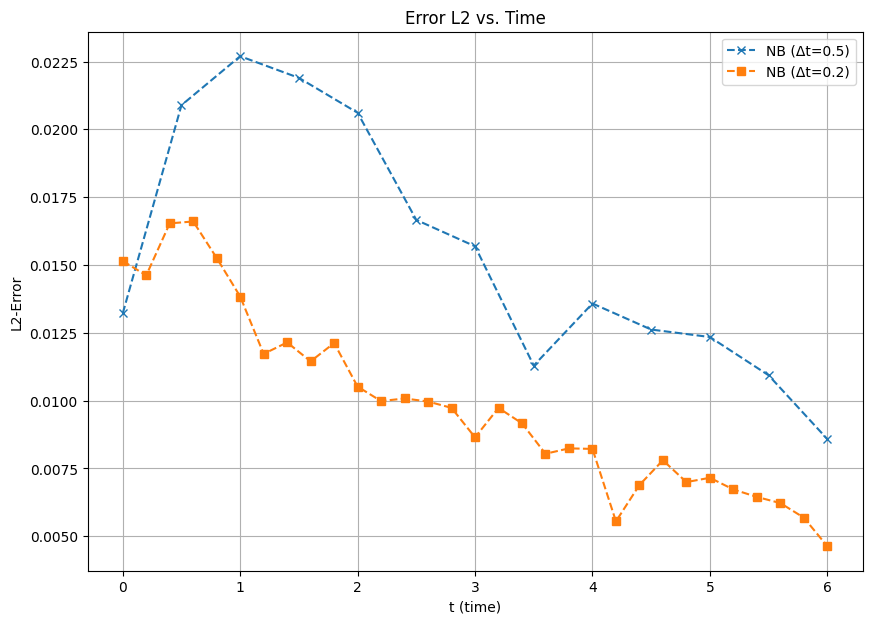

In [ ]:
from scipy.integrate import simpson
import numpy as np
import matplotlib.pyplot as plt

# Common parameters
N = 50000
epsilon = 1
T_final = 6.0       # tmax

# mesh parameters
Vmin, Vmax = -5, 5 # ranges for the mesh
deltaV = 0.0625
H = 0.2

def run_simulation_and_compute_error(time_step):
    print(f"Starting simulation with Δt = {time_step}")

    n_steps = int(T_final / time_step)

    # initialize
    v = np.zeros((N, n_steps + 1))
    v[:,0] = f0(N)

    # lists to store errors
    time_points = []
    error_list = []

    print("Computing error in t=0...")

    # error computation in t = 0
    current_time = 0.0
    VI, fVI = grid_f(v, Vmin, Vmax, deltaV, H, time=0)
    f_exact_on_grid = f(VI, current_time)
    squared_diff = (fVI/K - f_exact_on_grid)**2
    integral = simpson(squared_diff, x=VI)
    l2_error = np.sqrt(integral)

    time_points.append(current_time)
    error_list.append(l2_error)

    # loop for simulation and errors
    for t in range(n_steps):
        current_time = (t + 1) * time_step

        #simulation of first step
        v[:,t+1] = v[:,t]
        Nc = iround((mu*N*time_step)/(2*epsilon))

        if Nc > 0:
            try:
                colliding_indices = np.random.choice(N, 2 * Nc, replace=False)
                i_indx = colliding_indices[:Nc]
                j_indx = colliding_indices[Nc:]

                # simulate the collisions
                vi = v[i_indx, t+1]
                vj = v[j_indx, t+1]
                theta = np.random.uniform(0, 2*np.pi, Nc)

                v[i_indx, t+1] = vi * np.cos(theta) - vj * np.sin(theta)
                v[j_indx, t+1] = vi * np.sin(theta) + vj * np.cos(theta)

            except ValueError:
                print(f"Warning in t={t}: 2*Nc ({2*Nc}) > N ({N}).")
                # this is an error, if not continue without collision
                pass #

        # compute error for this time step
        VI, fVI = grid_f(v, Vmin, Vmax, deltaV, H, time=t+1)
        f_exact_on_grid = f(VI, current_time) # exact solution in same time

        # integral error L2
        squared_diff = (fVI/K - f_exact_on_grid)**2
        integral = simpson(squared_diff, x=VI)
        l2_error = np.sqrt(integral)

        # store results
        time_points.append(current_time)
        error_list.append(l2_error)
        # print(f"t = {current_time:.2f} | Error L2 = {l2_error:.4f}")

    return time_points, error_list

# Run for Delta t = 0.5
t1, err1 = run_simulation_and_compute_error(time_step=0.5)

# Run for Delta t = 0.2
t2, err2 = run_simulation_and_compute_error(time_step=0.2)

print("completed simulations")

# plotting
plt.figure(figsize=(10, 7))
plt.plot(t1, err1, marker='x', linestyle='--', label='NB (Δt=0.5)')
plt.plot(t2, err2, marker='s', linestyle='--', label='NB (Δt=0.2)')

plt.title("Error L2 vs. Time")
plt.xlabel("t (time)")
plt.ylabel("L2-Error")
plt.legend()
plt.grid(True)
plt.show()

We track the discrete $L^2$ error norm between the numerical reconstruction and the exact solution from t=0 to t=8, using different values for the time step Δt. The objective was to study how this error evolves when Δt tends to 0.

In [ ]:
#Experiment 1: Vary time_step


# Simulation Parameters
N = 50000
mu = 1.0       # Fixed
epsilon = 1.0  # Fixed
T_final = 8.0

# Mesh Parameters
Vmin, Vmax = -3, 3
deltaV = 0.0625
H = 0.2

# List of time_steps to test
time_step_values = [1.0, 0.5,0.1, 0.05,0.01]

# Plot
plt.figure(figsize=(12, 8))
plt.title("L2-Error vs. Time (for various Δt)")
plt.xlabel("t (time)")
plt.ylabel("L2-Error")
plt.grid(True)

# Main loop
for time_step in time_step_values:

    print(f"\n--- Starting simulation with Δt = {time_step} ---")

    n_steps = int(T_final / time_step)

    # Initial velocities
    v0 = f0(N)

    # Start the simulation
    v = np.zeros((N, n_steps + 1))
    v[:,0] = v0
    for t in range(n_steps):
        v[:,t+1] = v[:,t]
        Nc = iround((mu*N*time_step)/(2*epsilon))
        if Nc > 0:
            try:
                colliding_indices = np.random.choice(N, 2 * Nc, replace=False)
                i_indx = colliding_indices[:Nc]
                j_indx = colliding_indices[Nc:]
                for i, j in zip(i_indx, j_indx):
                      v[i,t+1], v[j,t+1] = collision(v[i,t+1], v[j,t+1])
            except ValueError:
                print(f"Warning at t={t}: 2*Nc ({2*Nc}) > N ({N}).")
                pass

    # compute the l2 errors for the simulation
    time_points = []
    error_list = []
    print(f"Calculating error for Δt = {time_step}...")

    for t_idx in range(n_steps + 1):
        current_time = t_idx * time_step

        VI, fVI = grid_f(v, Vmin, Vmax, deltaV, H, time=t_idx)

        # fVI/K to reescalate
        f_exact_on_grid = f(VI, current_time)
        squared_diff = (fVI/K - f_exact_on_grid)**2
        integral = simpson(squared_diff, VI)
        l2_error = np.sqrt(integral)

        time_points.append(current_time)
        error_list.append(l2_error)

    print(f"Simulation with Δt = {time_step} completed.")

    # Adding the line for the actual time_step into the plot
    plt.plot(time_points, error_list, marker='x', linestyle='--', label=f'NB (Δt={time_step})')

# final plot
plt.legend()
plt.show()


We track the discrete $L^2$ error norm between the numerical reconstruction and the exact solution from $t=0$ to $t=30$, using different values for the parameter $\varepsilon$. We plot one graphic representing the error for the different values of epsilon at each time checkpoint. We also plot one graphic for every time checkpoint showing the simulations for the different epsilon values, alongside the asymptotic and exact analytical solutions.

In [ ]:
# Experiment 2: Vary epsilon

# Simulation parameters (fixed)
N = 50000
mu = 1.0

# Mesh Parameters (fixed)
Vmin, Vmax = -3, 3
deltaV = 0.0625
H = 0.2

# list of epsilons to test
epsilon_values = [1.0, 0.75, 0.5, 0.35, 0.2, 0.1, 0.05, 0.02, 0.01,0.005]



# times we want to capture
T_checkpoints = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 18.0, 22.0, 26.0, 30.0]
T_max_sim = max(T_checkpoints)

# Dictionaries to store results for each time T
# errors_data[T] will contain a list of errors for all epsilons
errors_data = {t: [] for t in T_checkpoints}
# solutions_data[T] will contain tuples (epsilon, VI, fVI) for plotting
solutions_data = {t: [] for t in T_checkpoints}

# Main loop

for epsilon in epsilon_values:

    # Stability rule
    time_step = 0.2 * epsilon # We keep the rate (dt/eps) constant

    total_steps = int(T_max_sim / time_step)

    print(f"\n  --- ε = {epsilon} --- (Δt = {time_step:.4f}, Total Steps = {total_steps})")

    # Initial velocities
    v0 = f0(N)

    # Run the simulation
    v = np.zeros((N, total_steps + 1))
    v[:,0] = v0

    for t in range(total_steps):
        v[:,t+1] = v[:,t]
        Nc = iround((mu*N*time_step)/(2*epsilon))

        if Nc > 0:
            try:
                colliding_indices = np.random.choice(N, 2 * Nc, replace=False)
                i_indx = colliding_indices[:Nc]
                j_indx = colliding_indices[Nc:]
                for i, j in zip(i_indx, j_indx):
                      v[i,t+1], v[j,t+1] = collision(v[i,t+1], v[j,t+1])
            except ValueError:
                pass

        current_time = (t + 1) * time_step

        # We check if we are close to one of the target times
        for T_target in T_checkpoints:
            target_step = int(T_target / time_step)

            if (t + 1) == target_step:
                # We reach a checkpoint

                # Compute L2 error in specific T_final (T_target)
                VI, fVI = grid_f(v, Vmin, Vmax, deltaV, H, time=target_step)
                f_exact_on_grid = f(VI, T_target)

                # desnormalizing
                squared_diff = (fVI/K - f_exact_on_grid)**2
                integral = simpson(squared_diff, VI)
                l2_error = np.sqrt(integral)

                print(f"    Checkpoint T={T_target}: L2-Error = {l2_error:.4f}")

                # Store results
                errors_data[T_target].append(l2_error)
                solutions_data[T_target].append((epsilon, VI, fVI))

print("\nSimulations completed.")

# Plots

# 1. Plot graphic error vs epsilon
plt.figure(figsize=(10, 7))
for T_target in T_checkpoints:
    plt.plot(epsilon_values, errors_data[T_target], marker='o', linestyle='--', label=f'Time T={T_target}')

plt.xscale('log')
plt.title("L2 Error vs Epsilon  (Comparison for different times)")
plt.xlabel("Epsilon (ε) (Log)")
plt.ylabel("L2-Error")
plt.legend()
plt.grid(True, which="both")
plt.gca().invert_xaxis()
plt.savefig("Error_vs_Epsilon_MultiTime.png")
plt.show()

# 2. Plot analytical vs Monte Carlo solutions (one plot per time in Checktime)
for T_target in T_checkpoints:
    plt.figure(figsize=(12, 8))

    # plotting analytical solution (Black line) and asymptotic solutions (red dashed line)
    x_dense = np.linspace(Vmin, Vmax, 200)
    y_dense = f(x_dense, T_target)
    y2_dense = f_as(x_dense)
    plt.plot(x_dense, y_dense, color='black', linewidth=2.5, label=f'Analytical T={T_target}')


    # We plot simulation solutions for each epsilon
    # We use colormap to differenciate different values
    colors = plt.cm.viridis(np.linspace(0, 1, len(epsilon_values)))

    # Stored solutions for this time
    solutions_list = solutions_data[T_target]

    for idx, (eps, VI, fVI) in enumerate(solutions_list):
        # We plot fVI/K so it matches the analytical scale
        plt.plot(VI, fVI/K, linestyle='-', linewidth=1.5, color=colors[idx], label=f'MC ε={eps}')

    plt.plot(x_dense, y2_dense, color='red', linestyle = 'dashed', linewidth=2.5, label="Asymptotic solution")
    plt.title(f"Solution Comparison at Time T={T_target}")
    plt.xlabel("v (velocity)")
    plt.ylabel("f(v, t)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Solutions_Comparison_T_{int(T_target)}.png")
    plt.show()
